In [1]:
!pip install langgraph

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import langgraph
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

In [3]:
import os

llm = ChatOpenAI(model=os.getenv("OPENAI_DEFAULT_MODEL"))

In [4]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

class CodeInputs(TypedDict):
    code: str
    style_feedback: str
    bug_feedback: str
    optimization_feedback: str
    final_feedback: str

In [5]:
def code_style_check(inputs: CodeInputs):
    """코드 스타일 점검"""
    code = inputs["code"]
    prompt = (
        "다음 코드의 스타일을 점검하고 PEP8 준수 여부를 확인하세요:\n" + code
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    return {
        **inputs,
        "style_feedback": response.content
    }

def bug_detection(inputs: CodeInputs):
    """코드에서 버그 가능성 분석"""
    code = inputs["code"]
    prompt = (
        "다음 코드에서 잠재적인 버그나 논리적 오류를 찾아 설명하세요:\n" + code
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    return {
        **inputs,
        "bug_feedback": response.content
    }

def optimization_suggestions(inputs: CodeInputs):
    """코드 최적화 제안"""
    code = inputs["code"]
    prompt = (
        "다음 코드를 더 효율적으로 최적화할 수 있는 방법을 제안하세요:\n" + code
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    inputs["optimization_feedback"] = response.content
    return {
        **inputs,
        "optimization_feedback": response.content
    }

def aggregate_feedback(inputs):
    code = inputs["code"]
    """모든 피드백을 하나로 합쳐 반환"""
    feedback = (
        "코드 스타일 피드백:\n" + inputs["style_feedback"] + "\n\n"
        "버그 가능성 분석:\n" + inputs["bug_feedback"] + "\n\n"
        "최적화 제안:\n" + inputs["optimization_feedback"]
    )
    prompt = (
        "다음 코드와 피드백을 바탕으로 개선된 코드를 작성하세요. 반드시 코드만 출력해야 합니다.\n" + \
            "code: " + code + "\n\n" \
            "피드백: " + feedback
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    return {
        **inputs,
        "code": response.content,
        "final_feedback": feedback
    }


In [9]:
from langgraph.graph import END, StateGraph, START

# LangGraph 워크플로우 구축
graph = StateGraph(CodeInputs)
graph.add_node("style_check", code_style_check)
graph.add_node("bug_check", bug_detection)
graph.add_node("optimization_check", optimization_suggestions)
graph.add_node("aggregate", aggregate_feedback)

# 데이터 흐름 정의
graph.add_edge(START, "style_check")
graph.add_edge("style_check", "bug_check")
graph.add_edge("bug_check", "optimization_check")
graph.add_edge("optimization_check", "aggregate")
graph.add_edge("aggregate", END)

app = graph.compile()


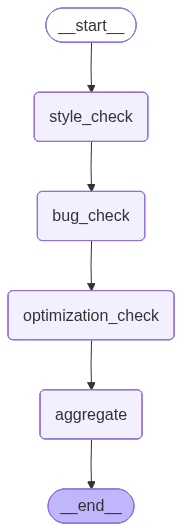

In [10]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
sample_code = """
def calcStats(data,  threshold=10):
    sum = 0  
    avg = 0
    for i in range(len(data)):
        sum = sum + data[i] 
    avg = sum/len(data) 

    above=[]
    for x in data:
        if x>threshold: above.append(x) 

    print ("평균:",avg)
    return {'SUM':sum, 'Average':avg, 'AboveThreshold':above}
"""
result = app.invoke({"code": sample_code})
print(result["final_feedback"])

코드 스타일 피드백:
주어진 코드를 PEP 8 스타일 가이드에 따라 점검해보겠습니다. PEP 8은 Python 스타일 가이드로, 코드의 가독성을 높이기 위한 규칙을 제공합니다. 아래는 주석과 함께 수정 권장 사항입니다.

```python
def calc_stats(data, threshold=10):
    total_sum = 0   # 'sum'은 내장 함수 이름과 동일하므로 더 구체적인 이름 사용
    avg = 0
    for i in range(len(data)):
        total_sum += data[i]  # 더 간결한 방법으로 수정
    avg = total_sum / len(data)  # 변수 이름도 더 적절하게 변경

    above = []  # 공백을 넣어 가독성 향상
    for x in data:
        if x > threshold:
            above.append(x)  # 조건문에 따라서 명확한 출력

    print("평균:", avg)  # 공백 정렬 및 불필요한 공백 제거
    return {'SUM': total_sum, 'Average': avg, 'AboveThreshold': above}  # 변수 이름 통일성과 일관성 유지
```

### PEP 8 준수 여부 및 수정 사항
1. **함수명**: 함수명을 snake_case 스타일(`calc_stats`)로 변경했습니다.
2. **변수명**: 변수명인 `sum`을 `total_sum`으로 변경했습니다. `sum`은 내장 함수의 이름이므로 이를 피하는 것이 좋습니다.
3. **가독성 개선**:
   - `total_sum = total_sum + data[i]`는 `total_sum += data[i]`로 간단히 표현할 수 있습니다.
   - 리스트 초기화를 위한 줄을 공백을 추가하여 가독성을 높였습니다.
   - `if` 문과 `append` 코드 블록 사이에 항상 공백을 추가하는 것이 좋습니다.
4. **출력문**: `p

In [12]:
print(result["code"])

```python
def calc_stats(data, threshold=10):
    if len(data) == 0:
        return {'SUM': 0, 'Average': 0, 'AboveThreshold': []}

    total_sum = 0
    above = []
    n = len(data)

    for x in data:
        total_sum += x
        if x > threshold:
            above.append(x)

    avg = total_sum / n

    print("평균:", avg)
    return {'SUM': total_sum, 'Average': avg, 'AboveThreshold': above}
```
